<a href="https://colab.research.google.com/github/kbhatia99/online_deep_learning6/blob/main/High_Risk_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Step 1: Upload kaggle.json (if not already done)
from google.colab import files
files.upload()  # Upload kaggle.json here

# Step 2: Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download and unzip dataset
!kaggle datasets download -d simhadrisadaram/mimic-cxr-csv
!unzip mimic-cxr-csv.zip -d mimic_cxr_csv

# Step 4: Check what files are available
!ls mimic_cxr_csv


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/simhadrisadaram/mimic-cxr-csv
License(s): CC0-1.0
Archive:  mimic-cxr-csv.zip
  inflating: mimic_cxr_csv/mimic_cxr_aug_train.csv  
  inflating: mimic_cxr_csv/mimic_cxr_aug_validate.csv  
mimic_cxr_aug_train.csv  mimic_cxr_aug_validate.csv


In [ ]:
!pip install openai==0.28



🗕️ Processing file: /content/mimic_cxr_csv/mimic_cxr_aug_train.csv
 Saved results to /content/simplified_train.csv

🗕️ Processing file: /content/mimic_cxr_csv/mimic_cxr_aug_validate.csv
 Saved results to /content/simplified_validate.csv


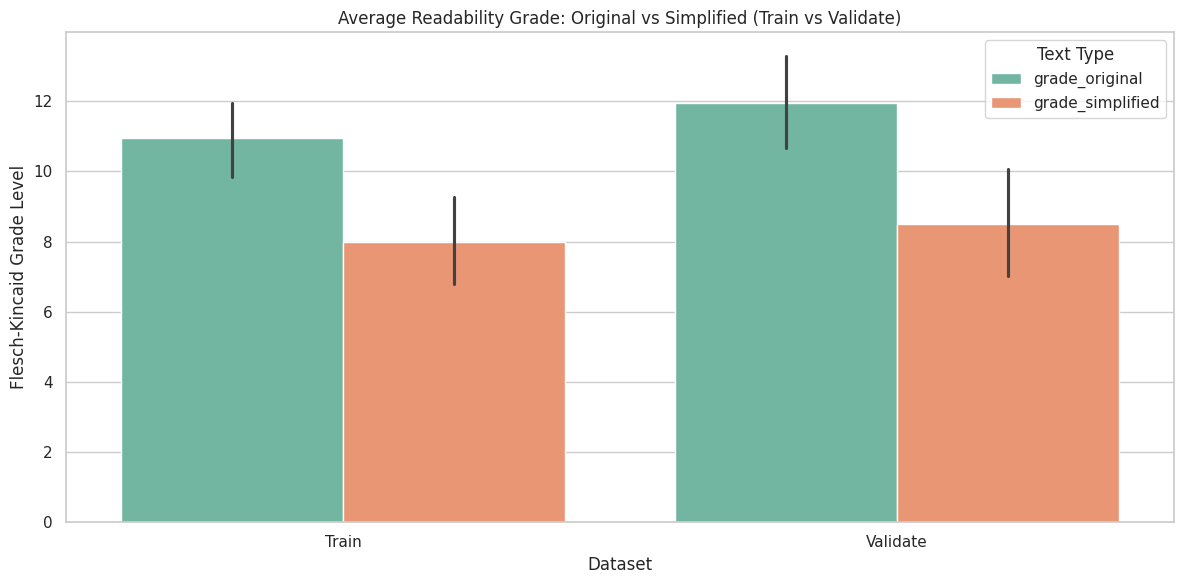

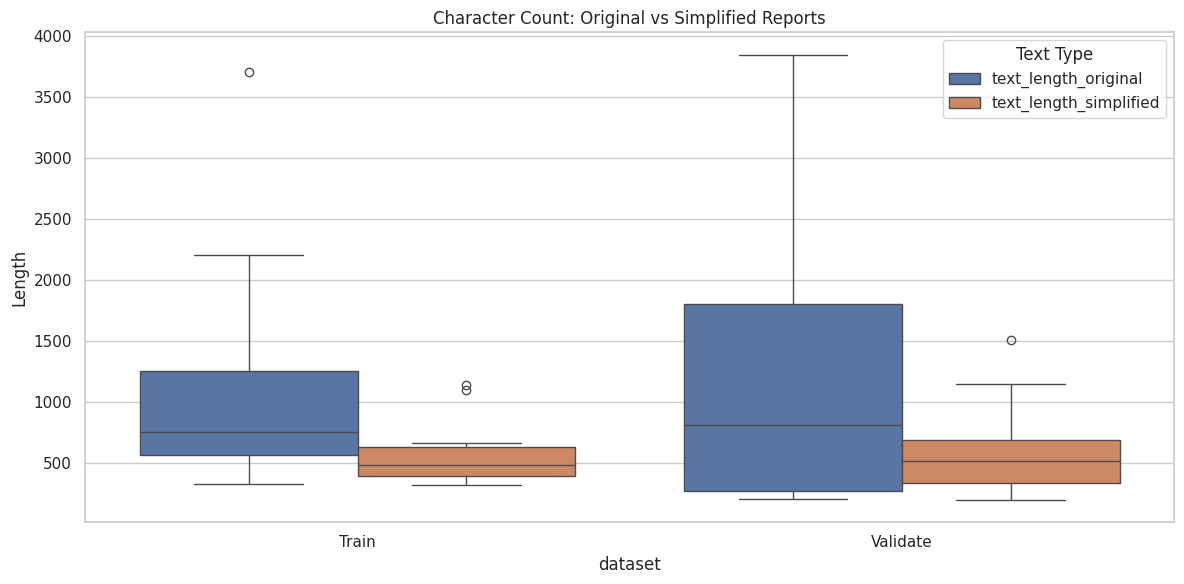

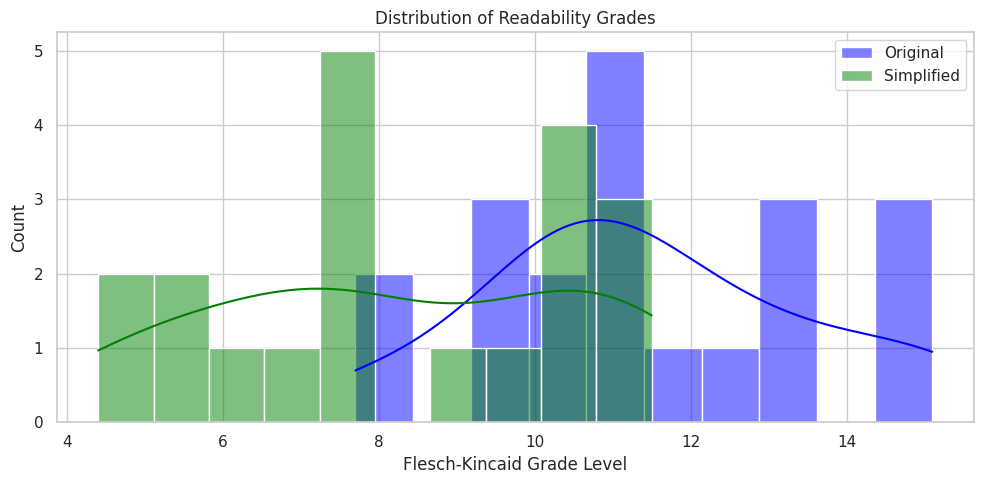

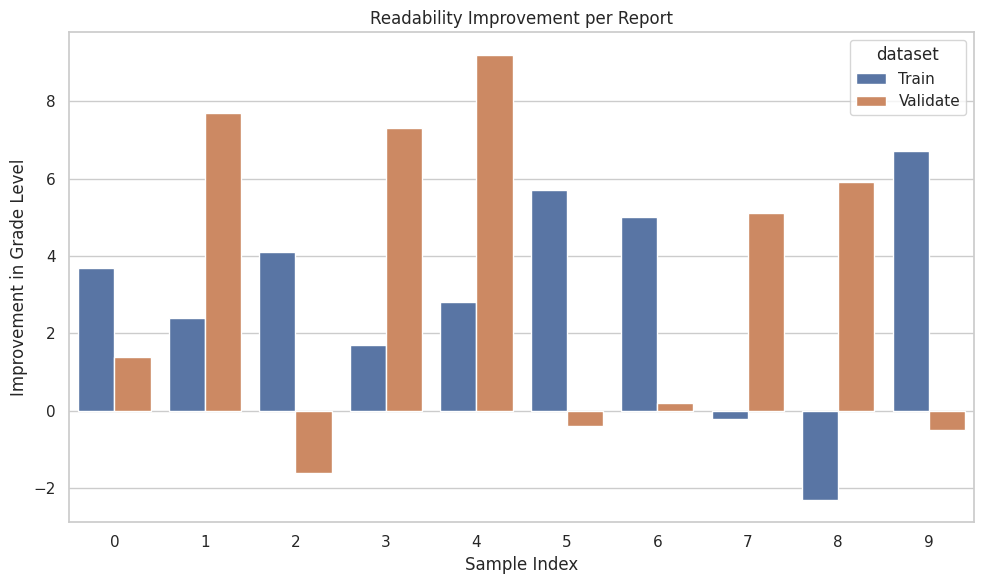

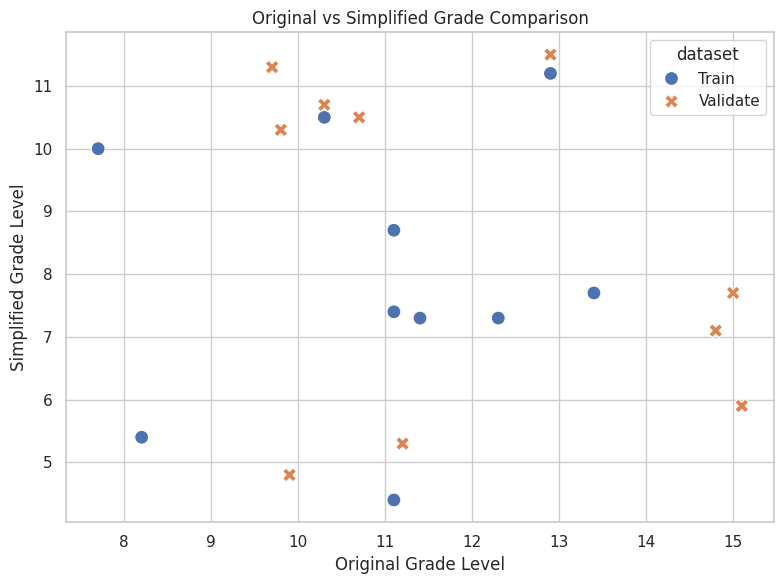


Readability Summary by Dataset:
         grade_original                                                   \
                  count   mean       std  min   25%    50%     75%   max   
dataset                                                                    
Train              10.0  10.95  1.839233  7.7  10.5  11.10  12.075  13.4   
Validate           10.0  11.94  2.284829  9.7  10.0  10.95  14.325  15.1   

         grade_simplified        ...               improvement        \
                    count  mean  ...     75%   max       count  mean   
dataset                          ...                                   
Train                10.0  7.99  ...   9.675  11.2        10.0  2.96   
Validate             10.0  8.51  ...  10.650  11.5        10.0  3.43   

                                                  
               std  min    25%   50%    75%  max  
dataset                                           
Train     2.730161 -2.3  1.875  3.25  4.775  6.7  
Validate  4.018858 -1

In [2]:
# Required Libraries
!pip install -q openai pandas textstat matplotlib seaborn

import pandas as pd
import openai
import textstat
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Set your OpenAI API key
openai.api_key = "sk-testA"  # Replace with your actual key

# GPT Simplification Function
def simplify_report(text):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a medical assistant helping patients understand radiology reports."},
                {"role": "user", "content": f"Please simplify this radiology report in layman terms:\n{text}"}
            ]
        )
        return response['choices'][0]['message']['content']
    except Exception as e:
        print("Error:", e)
        return ""

# Readability Calculator
def get_readability(text):
    try:
        return textstat.flesch_kincaid_grade(text)
    except:
        return -1

# Run pipeline on any CSV file
def run_pipeline(csv_path, output_csv, label):
    print(f"\n🗕️ Processing file: {csv_path}")
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=['text'])
    df_sample = df.head(10).copy()

    df_sample['simplified'] = df_sample['text'].apply(lambda x: simplify_report(x))
    df_sample['grade_original'] = df_sample['text'].apply(get_readability)
    df_sample['grade_simplified'] = df_sample['simplified'].apply(get_readability)
    df_sample['text_length_original'] = df_sample['text'].apply(len)
    df_sample['text_length_simplified'] = df_sample['simplified'].apply(len)
    df_sample['dataset'] = label

    df_sample.to_csv(output_csv, index=False)
    print(f" Saved results to {output_csv}")
    return df_sample

# Run both training and validation files
df_train = run_pipeline("/content/mimic_cxr_csv/mimic_cxr_aug_train.csv", "/content/simplified_train.csv", "Train")
df_val = run_pipeline("/content/mimic_cxr_csv/mimic_cxr_aug_validate.csv", "/content/simplified_validate.csv", "Validate")

# Combine for Analysis
combined_df = pd.concat([df_train, df_val])
sns.set(style="whitegrid")

#  Plot 1: Average Readability Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df.melt(id_vars=['dataset'], value_vars=['grade_original', 'grade_simplified'],
                                   var_name='Type', value_name='Grade'),
            x='dataset', y='Grade', hue='Type', palette='Set2')
plt.title('Average Readability Grade: Original vs Simplified (Train vs Validate)')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.xlabel('Dataset')
plt.legend(title='Text Type')
plt.tight_layout()
plt.show()

# 📈 Plot 2: Length of Text Before and After Simplification
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df.melt(id_vars=['dataset'], value_vars=['text_length_original', 'text_length_simplified'],
                                  var_name='Text Type', value_name='Length'), x='dataset', y='Length', hue='Text Type')
plt.title('Character Count: Original vs Simplified Reports')
plt.tight_layout()
plt.show()

#  Plot 3: Distribution of Readability Scores
plt.figure(figsize=(10, 5))
sns.histplot(data=combined_df, x='grade_original', label='Original', color='blue', kde=True, bins=10)
sns.histplot(data=combined_df, x='grade_simplified', label='Simplified', color='green', kde=True, bins=10)
plt.title('Distribution of Readability Grades')
plt.xlabel('Flesch-Kincaid Grade Level')
plt.legend()
plt.tight_layout()
plt.show()

#  Plot 4: Improvement per Report
plt.figure(figsize=(10, 6))
combined_df['improvement'] = combined_df['grade_original'] - combined_df['grade_simplified']
sns.barplot(data=combined_df, x=combined_df.index, y='improvement', hue='dataset')
plt.title('Readability Improvement per Report')
plt.xlabel('Sample Index')
plt.ylabel('Improvement in Grade Level')
plt.tight_layout()
plt.show()

#  Plot 5: Scatter Plot of Original vs Simplified Readability
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x='grade_original', y='grade_simplified', hue='dataset', style='dataset', s=100)
plt.title('Original vs Simplified Grade Comparison')
plt.xlabel('Original Grade Level')
plt.ylabel('Simplified Grade Level')
plt.tight_layout()
plt.show()

#  Summary Statistics
print("\nReadability Summary by Dataset:")
print(combined_df.groupby('dataset')[['grade_original', 'grade_simplified', 'improvement']].describe())
